### Introduction to Preprocessing and Training Stage (Hard Court Version)

The goal of this stage is to create a training-testing split in the predictive features and target feature (% total points won by a given player in a given match), and to create a few simple benchmark models against which the more complex models will be compared in terms of prediction accuracy. 

Prediction is to be carried out at the player level for a given match (so each match in the sample has two records associated with it). Performance features used for prediction of a given player's % pts won in a given match are accrued based on surface-specific match data in matches PRIOR TO BUT NOT INCLDING the match being predicted on (NOR including any matches player AFTER the match being predicted on). 

"Raw" features are specific to one of the two players in a given match (eg, log of ranking, height, handedness, time decay-weighted past serve or return points won%, decay-weighted time on court previously in the same tournament), or represent metadata pertinent to player-independent aspects of a match (eg, surface, court speed, location) . 

"Differential" features are derivatives of the "raw" features where a subtraction is done between the two players in the match being predicted on (Player X - Player Y or Player Y - Player X). For example, if Player X won 55% of his serve points (time-decay weighted) in his prior 60 matches on the same surface as the match to be predicted on, and his opponent Player Y won 47% of his own serve points (time-decay weighted) in his prior 60 matches on the same surface, the "differential" feature value "p_pts_sv_won_l60_decay_diff" for Player X would be 55 - 47 = 8% and for Player Y would be 47 - 55 = -8%. The according "raw" feature values, in turn, "p_pts_sv_won_l60_decay" would be 55% and 47% for Player X and Player Y, respectively. 

Currently, data (on a surface-specific basis) from years 2015-2019 are used in EDA/modeling for hard court matches (2012-2019 for the smaller sample size/year clay court match sample), with an additional 3 years prior to that used for retrospective feature accrual (2009-2011 for clay court matches, 2012-2014 for hard court matches). Also, a threshold of minimum of 20 prior matches for BOTH players in a given match to be predicted on is employed. Not surprisingly, prediction accuracy is sensitive to the amount of data available to generate predictive features, as well as to the amount of data available to train and test the model. Critically, matches filtered out at the current point and beyond (ie, during modeling) WERE used for feature generation.
    * As an additional data inclusion reminder, matches played on grass (too low a sample size; also removed Davis Cup and Olympics matches for same reason as well as for their "odd" contexts) and matches where one player withdrew (usually for injury reason) either before the match or early on (<12 games in) in the match were filtered out and NOT included in feature generation.    

Two simple benchmarking models are created below:
* A "dummy" model, which simply uses the mean of the training data split to predict the target of % points won by a given player in a given match
* A simple multivariate linear model that utilizes only ATP ranking information, both raw ranking and differential ranking between the two players in the match being predicted on, to predict the target. Given that tournament entry and seeding are determined primarily by ranking data by the tour itself, this simple model can very prudently be seen as a fair benchmark for any system hoping to predict player performance on a move-forward basis.

## Preprocessing and Training

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load Data

In [2]:
df = pd.read_csv('../data/df_player_benchmark_hard.csv')
df.head()

,p_pts_won%,p_rank,p_log_rank,p_rank_pts,p_opp_rank_diff,p_opp_log_rank_diff,p_opp_rank_pts_diff,p_matches_surf,t_indoor,m_num,tour_wk
0,47.84,1415.0,7.25,3.0,-1280.0,-2.34,-393.0,1.0,0,2682,2019_24
1,41.29,1491.0,7.31,2.0,-993.0,-1.10,-57.0,1.0,1,1495,2019_29
2,37.23,2130.0,7.66,0.0,-2059.0,-3.40,-753.0,1.0,0,38,2019_07
3,59.14,95.0,4.55,596.0,-77.0,-1.66,-1179.0,12.0,1,202,2019_33
4,53.66,95.0,4.55,596.0,-35.0,-0.46,-305.0,11.0,1,541,2019_33


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23608 entries, 0 to 23607
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   p_pts_won%           23608 non-null  float64
 1   p_rank               23608 non-null  float64
 2   p_log_rank           23608 non-null  float64
 3   p_rank_pts           23608 non-null  float64
 4   p_opp_rank_diff      23608 non-null  float64
 5   p_opp_log_rank_diff  23608 non-null  float64
 6   p_opp_rank_pts_diff  23608 non-null  float64
 7   p_matches_surf       23608 non-null  float64
 8   t_indoor             23608 non-null  int64  
 9   m_num                23608 non-null  int64  
 10  tour_wk              23608 non-null  object 
dtypes: float64(8), int64(2), object(1)
memory usage: 2.0+ MB


### Filter Data

See notebook Intro for details and justification. 

In [4]:
# full best model includes 2015-2019 for hard courts (empirically determined as optimal in Tennis Prediction Project). So we 
# mirror that in the bechmarking here

df_filter = df[~df['tour_wk'].str.contains("2012")] 
df_filter = df_filter[~df_filter['tour_wk'].str.contains("2013")]
df_filter = df_filter[~df_filter['tour_wk'].str.contains("2014")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2015")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2016")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2017")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2018")]
#df_filter = df_filter[~df_filter['tour_wk'].str.contains("2019")]

In [5]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14864 entries, 0 to 23606
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   p_pts_won%           14864 non-null  float64
 1   p_rank               14864 non-null  float64
 2   p_log_rank           14864 non-null  float64
 3   p_rank_pts           14864 non-null  float64
 4   p_opp_rank_diff      14864 non-null  float64
 5   p_opp_log_rank_diff  14864 non-null  float64
 6   p_opp_rank_pts_diff  14864 non-null  float64
 7   p_matches_surf       14864 non-null  float64
 8   t_indoor             14864 non-null  int64  
 9   m_num                14864 non-null  int64  
 10  tour_wk              14864 non-null  object 
dtypes: float64(8), int64(2), object(1)
memory usage: 1.4+ MB


In [6]:
# Filter down to only matches played on hard courts 
#df_filter2 = df_filter.loc[(df_filter["t_surf"] == 2)]
#df_filter2 = df_filter.loc[(df_filter["t_surf"] == 2) & (df_filter["p_matches_surf"] > 50)]

In [7]:
# Now also will remove BOTH players from individual matches remaining in the surface-specific sample already filtered by year range
# where one or both players has played N or fewer matches prior to the one to be predicted on. 
df_low = df_filter.loc[df_filter['p_matches_surf'] <= 20, 'm_num']
df_filter2 = df_filter[~df_filter['m_num'].isin(df_low)]

In [8]:
df_filter2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10718 entries, 25 to 23586
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   p_pts_won%           10718 non-null  float64
 1   p_rank               10718 non-null  float64
 2   p_log_rank           10718 non-null  float64
 3   p_rank_pts           10718 non-null  float64
 4   p_opp_rank_diff      10718 non-null  float64
 5   p_opp_log_rank_diff  10718 non-null  float64
 6   p_opp_rank_pts_diff  10718 non-null  float64
 7   p_matches_surf       10718 non-null  float64
 8   t_indoor             10718 non-null  int64  
 9   m_num                10718 non-null  int64  
 10  tour_wk              10718 non-null  object 
dtypes: float64(8), int64(2), object(1)
memory usage: 1004.8+ KB


Stripping dataframe down to only the raw an differential rankings-based features we will need to generate a "benchmarking" linear model. 

In [9]:
df_model1 = df_filter2[["p_pts_won%", "p_rank", "p_opp_rank_diff"]]

In [10]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10718 entries, 25 to 23586
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p_pts_won%       10718 non-null  float64
 1   p_rank           10718 non-null  float64
 2   p_opp_rank_diff  10718 non-null  float64
dtypes: float64(3)
memory usage: 334.9 KB


### Train Test Split

In [11]:
len(df_model1) * .75, len(df_model1) * .25

(8038.5, 2679.5)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='p_pts_won%'), 
                                                    df_model1["p_pts_won%"], test_size=0.25, 
                                                    random_state=47)

In [13]:
y_train.shape, y_test.shape

((8038,), (2680,))

In [14]:
y_train

9358     46.43
14240    70.67
8645     42.15
4352     52.94
16791    48.00
         ...  
5655     48.92
18275    42.11
13295    46.56
3842     54.12
10151    55.14
Name: p_pts_won%, Length: 8038, dtype: float64

In [15]:
X_train.shape, X_test.shape

((8038, 2), (2680, 2))

### Pre-Modeling: Mean Points Won% by a Given Player in Given Match as Predictor (aka "Dummy Model")

In [16]:
#Target feature (p_pts_won%) training set mean
train_mean = y_train.mean()
train_mean

50.01835157999501

In [17]:
#Fitting dummy regressor to training data (from sklearn). Outputs the training set mean.
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[50.01835158]])

In [18]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([50.01835158, 50.01835158, 50.01835158, 50.01835158, 50.01835158])

In [19]:
y_te_pred = train_mean * np.ones(len(y_test))

#### R-Squared (COD)

In [20]:
#Compute R-squared for target mean on training set (will be zero, since we are calculating mean on training set), and on test set (should be slightly different from zero)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.00014105155442845074)

proportion of the variance for a dependent variable that's explained by our features. It's close to zero for the dummy model as expected.

#### Mean Absolute Error (MAE)

In [21]:
MAEs_dummy = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
MAEs_dummy

(5.007099395252495, 5.0463236418059)

On average, we might expect to be off by around 5.01% on training set data and 5.05% on test data if you guessed a given player's percentage of points won in a given match based simply on an average of known values.

#### Mean Squared Error (MSE)

In [22]:
#Calculate the Mean Squared Error (average of the square of the errors)
MSEs_dummy = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
MSEs_dummy

(37.978029218516404, 38.19339080404433)

#### Root Mean Squared Error (RMSE)

In [23]:
RMSEs_dummy = np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred))
RMSEs_dummy

(6.162631679608673, 6.180080161619615)

The Dummy Model above is the ultimate straw man (we sure hope we can beat guessing with the average with all of the great data we have!). A slightly more fair comparison to our ultimate feature-rich model is a Linear Model based simply on the past match data provided by the ATP, namely player ranking and player ranking points. The ATP uses this data to decide on tournament entry status and seedings, so there is assuredly trust in these metrics by the governing body of tennis as far as evaluating players on tour. 

### Linear Model Prediction With Player Ranking Data Only (Raw and Differential)

In [24]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8038 entries, 9358 to 10151
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   p_rank           8038 non-null   float64
 1   p_opp_rank_diff  8038 non-null   float64
dtypes: float64(2)
memory usage: 188.4 KB


In [25]:
#Filter existing train-test split down to just the ranking columns (train)
#X_train_ranking = X_train[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [26]:
#Filter existing train-test split down to just the ranking columns (test)
#X_test_ranking = X_test[["p_rank", "p_rank_pts", "p_log_rank", "p_opp_rank_diff", "p_opp_rank_pts_diff", "p_opp_log_rank_diff"]]

In [27]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [28]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [29]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [30]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [31]:
#Conduct grid search for this ranking-restricted model. 
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001F32FD03CA0>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1, 2],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [32]:
#Best params from grid search for this ranking-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'mean',
 'standardscaler': None}

#### K Best Features Visualization

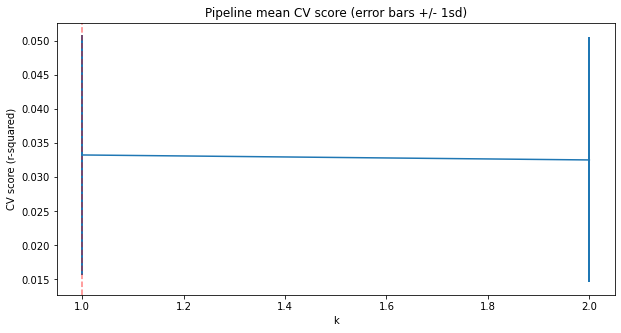

In [33]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Linear Model From Player Rankings and Player Ranking Differential Performance Metrics

#### R-squared (COD)

In [34]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

array([0.04957578, 0.0013785 , 0.02816769, 0.04663746, 0.04060875])

In [35]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(0.033273635429205604, 0.01755862213290566)

#### Mean Absolute Error (MAE)

In [36]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [37]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(4.875390404431974, 0.07301751910728473)

In [38]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

4.916184541124076

#### Mean Squared Error (MSE)

In [39]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

In [40]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(36.71242495590601, 1.2520209032778007)

In [41]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

37.45639086585906

#### Root Mean Square Error (RMSE)

In [42]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

In [43]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(6.058187478022364, 0.10387221495197616)

In [44]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

6.1201626502781

### Best Linear Model Feature Importance

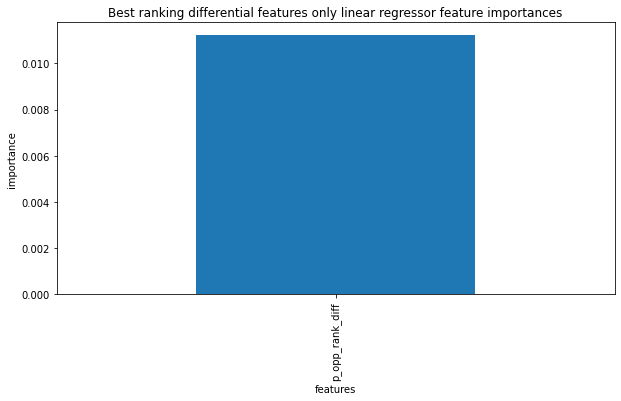

In [45]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best ranking differential features only linear regressor feature importances');

### Conclusions

So a simple linear model including only ranking and ranking derivative information outperformed the "dummy" model (RMSE,STD when applicable): 

* Dummy Model: 6.16% Train; 6.18% Test
* Linear Model Using Ranking Data Only: 6.06% (.10%) Train; 6.12% Test

* Also, not surprisingly based on both the EDA correlational analysis and intuition, the non-differential ranking feature failed to improve prediction above and beyond the player differential version. 

### Save Best Simple Linear Model Object From Pipeline

In [46]:
# save the best linear model
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
save_file(best_model, 'ranking_linearmodel_hard.pkl', modelpath)

A file already exists with this name.

Do you want to overwrite? (Y/N)Y
Writing file.  "../models\ranking_linearmodel_hard.pkl"


### Save Prediction Metrics from Dummy and Ranking-Based Linear Regression Models

In [47]:
# save other data for model comparisons in machine learning model stage
comp_data_from4 = (MAEs_dummy, MSEs_dummy, RMSEs_dummy, MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
with open('../data/comp_data_from4_hard.pickle', 'wb') as f:
    pickle.dump(comp_data_from4, f)